In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : False,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(676113, 1040)
(676113, 3)
validation
(118211, 1040)
(118211, 3)
test
(86404, 1040)
(86404, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1755395 (6.70 MB)


Trainable params: 1755395 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/68 [..............................] - ETA: 1:23 - loss: 1.3494 - STD: 0.1217 - MAE: 0.4897

 4/68 [>.............................] - ETA: 1s - loss: 1.0364 - STD: 0.1481 - MAE: 0.4107  

 7/68 [==>...........................] - ETA: 1s - loss: 0.9890 - STD: 0.1800 - MAE: 0.3878

10/68 [===>..........................] - ETA: 1s - loss: 0.9732 - STD: 0.1967 - MAE: 0.3766

13/68 [====>.........................] - ETA: 1s - loss: 0.9569 - STD: 0.2037 - MAE: 0.3697

16/68 [======>.......................] - ETA: 1s - loss: 0.9394 - STD: 0.2079 - MAE: 0.3638

19/68 [=======>......................] - ETA: 0s - loss: 0.9142 - STD: 0.2098 - MAE: 0.3571

22/68 [========>.....................] - ETA: 0s - loss: 0.8821 - STD: 0.2124 - MAE: 0.3481

25/68 [==========>...................] - ETA: 0s - loss: 0.8448 - STD: 0.2189 - MAE: 0.3360

28/68 [===========>..................] - ETA: 0s - loss: 0.8074 - STD: 0.2294 - MAE: 0.3218

31/68 [============>.................] - ETA: 0s - loss: 0.7732 - STD: 0.2420 - MAE: 0.3070

34/68 [==============>...............] - ETA: 0s - loss: 0.7435 - STD: 0.2546 - MAE: 0.2931

37/68 [===============>..............] - ETA: 0s - loss: 0.7158 - STD: 0.2659 - MAE: 0.2803

40/68 [================>.............] - ETA: 0s - loss: 0.6922 - STD: 0.2755 - MAE: 0.2695

43/68 [=================>............] - ETA: 0s - loss: 0.6704 - STD: 0.2831 - MAE: 0.2605

46/68 [===================>..........] - ETA: 0s - loss: 0.6505 - STD: 0.2893 - MAE: 0.2527

49/68 [====================>.........] - ETA: 0s - loss: 0.6321 - STD: 0.2951 - MAE: 0.2455

52/68 [=====================>........] - ETA: 0s - loss: 0.6148 - STD: 0.3011 - MAE: 0.2383

55/68 [=======================>......] - ETA: 0s - loss: 0.6015 - STD: 0.3068 - MAE: 0.2317

58/68 [========================>.....] - ETA: 0s - loss: 0.5870 - STD: 0.3117 - MAE: 0.2258

61/68 [=========================>....] - ETA: 0s - loss: 0.5736 - STD: 0.3159 - MAE: 0.2205

64/68 [===========================>..] - ETA: 0s - loss: 0.5614 - STD: 0.3198 - MAE: 0.2156

67/68 [============================>.] - ETA: 0s - loss: 0.5503 - STD: 0.3236 - MAE: 0.2110

68/68 [==============================] - 4s 40ms/step - loss: 0.5465 - STD: 0.3248 - MAE: 0.2096 - val_loss: 0.2952 - val_STD: 0.3935 - val_MAE: 0.1166


Epoch 2/10000


 1/68 [..............................] - ETA: 4s - loss: 0.3041 - STD: 0.4007 - MAE: 0.1145

 4/68 [>.............................] - ETA: 1s - loss: 0.3008 - STD: 0.4009 - MAE: 0.1137

 7/68 [==>...........................] - ETA: 1s - loss: 0.2965 - STD: 0.4016 - MAE: 0.1123

10/68 [===>..........................] - ETA: 1s - loss: 0.2932 - STD: 0.4035 - MAE: 0.1102

13/68 [====>.........................] - ETA: 1s - loss: 0.2916 - STD: 0.4042 - MAE: 0.1094

16/68 [======>.......................] - ETA: 1s - loss: 0.2896 - STD: 0.4046 - MAE: 0.1087

19/68 [=======>......................] - ETA: 1s - loss: 0.2887 - STD: 0.4053 - MAE: 0.1081

22/68 [========>.....................] - ETA: 0s - loss: 0.2869 - STD: 0.4059 - MAE: 0.1074

25/68 [==========>...................] - ETA: 0s - loss: 0.2851 - STD: 0.4063 - MAE: 0.1067

28/68 [===========>..................] - ETA: 0s - loss: 0.2828 - STD: 0.4069 - MAE: 0.1058

31/68 [============>.................] - ETA: 0s - loss: 0.2810 - STD: 0.4075 - MAE: 0.1050

34/68 [==============>...............] - ETA: 0s - loss: 0.2786 - STD: 0.4082 - MAE: 0.1041

37/68 [===============>..............] - ETA: 0s - loss: 0.2771 - STD: 0.4086 - MAE: 0.1035

40/68 [================>.............] - ETA: 0s - loss: 0.2752 - STD: 0.4091 - MAE: 0.1028

43/68 [=================>............] - ETA: 0s - loss: 0.2737 - STD: 0.4096 - MAE: 0.1022

46/68 [===================>..........] - ETA: 0s - loss: 0.2719 - STD: 0.4100 - MAE: 0.1014

49/68 [====================>.........] - ETA: 0s - loss: 0.2698 - STD: 0.4106 - MAE: 0.1005

52/68 [=====================>........] - ETA: 0s - loss: 0.2683 - STD: 0.4111 - MAE: 0.0998

55/68 [=======================>......] - ETA: 0s - loss: 0.2669 - STD: 0.4115 - MAE: 0.0993

58/68 [========================>.....] - ETA: 0s - loss: 0.2651 - STD: 0.4120 - MAE: 0.0985

61/68 [=========================>....] - ETA: 0s - loss: 0.2634 - STD: 0.4124 - MAE: 0.0979

64/68 [===========================>..] - ETA: 0s - loss: 0.2619 - STD: 0.4128 - MAE: 0.0973

67/68 [============================>.] - ETA: 0s - loss: 0.2605 - STD: 0.4133 - MAE: 0.0966

68/68 [==============================] - 2s 26ms/step - loss: 0.2599 - STD: 0.4134 - MAE: 0.0964 - val_loss: 0.2244 - val_STD: 0.4159 - val_MAE: 0.0870


Epoch 3/10000


 1/68 [..............................] - ETA: 3s - loss: 0.2179 - STD: 0.4230 - MAE: 0.0808

 4/68 [>.............................] - ETA: 1s - loss: 0.2176 - STD: 0.4246 - MAE: 0.0793

 7/68 [==>...........................] - ETA: 1s - loss: 0.2166 - STD: 0.4242 - MAE: 0.0795

10/68 [===>..........................] - ETA: 1s - loss: 0.2170 - STD: 0.4241 - MAE: 0.0796

13/68 [====>.........................] - ETA: 1s - loss: 0.2164 - STD: 0.4241 - MAE: 0.0794

16/68 [======>.......................] - ETA: 1s - loss: 0.2152 - STD: 0.4246 - MAE: 0.0789

19/68 [=======>......................] - ETA: 1s - loss: 0.2155 - STD: 0.4245 - MAE: 0.0790

22/68 [========>.....................] - ETA: 1s - loss: 0.2144 - STD: 0.4248 - MAE: 0.0786

25/68 [==========>...................] - ETA: 0s - loss: 0.2119 - STD: 0.4250 - MAE: 0.0779

28/68 [===========>..................] - ETA: 0s - loss: 0.2097 - STD: 0.4254 - MAE: 0.0773

31/68 [============>.................] - ETA: 0s - loss: 0.2082 - STD: 0.4258 - MAE: 0.0767

34/68 [==============>...............] - ETA: 0s - loss: 0.2061 - STD: 0.4261 - MAE: 0.0761

37/68 [===============>..............] - ETA: 0s - loss: 0.2039 - STD: 0.4266 - MAE: 0.0753

40/68 [================>.............] - ETA: 0s - loss: 0.2020 - STD: 0.4270 - MAE: 0.0746

43/68 [=================>............] - ETA: 0s - loss: 0.2003 - STD: 0.4275 - MAE: 0.0739

46/68 [===================>..........] - ETA: 0s - loss: 0.1985 - STD: 0.4279 - MAE: 0.0733

49/68 [====================>.........] - ETA: 0s - loss: 0.1967 - STD: 0.4283 - MAE: 0.0727

52/68 [=====================>........] - ETA: 0s - loss: 0.1949 - STD: 0.4287 - MAE: 0.0721

55/68 [=======================>......] - ETA: 0s - loss: 0.1935 - STD: 0.4289 - MAE: 0.0717

58/68 [========================>.....] - ETA: 0s - loss: 0.1920 - STD: 0.4293 - MAE: 0.0712

61/68 [=========================>....] - ETA: 0s - loss: 0.1902 - STD: 0.4296 - MAE: 0.0706

64/68 [===========================>..] - ETA: 0s - loss: 0.1890 - STD: 0.4299 - MAE: 0.0701

67/68 [============================>.] - ETA: 0s - loss: 0.1878 - STD: 0.4303 - MAE: 0.0696

68/68 [==============================] - 2s 27ms/step - loss: 0.1875 - STD: 0.4304 - MAE: 0.0695 - val_loss: 0.1803 - val_STD: 0.4347 - val_MAE: 0.0651


Epoch 4/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1474 - STD: 0.4381 - MAE: 0.0559

 4/68 [>.............................] - ETA: 1s - loss: 0.1512 - STD: 0.4389 - MAE: 0.0564

 7/68 [==>...........................] - ETA: 1s - loss: 0.1511 - STD: 0.4386 - MAE: 0.0566

10/68 [===>..........................] - ETA: 1s - loss: 0.1506 - STD: 0.4388 - MAE: 0.0563

13/68 [====>.........................] - ETA: 1s - loss: 0.1515 - STD: 0.4391 - MAE: 0.0562

16/68 [======>.......................] - ETA: 1s - loss: 0.1513 - STD: 0.4393 - MAE: 0.0560

19/68 [=======>......................] - ETA: 1s - loss: 0.1504 - STD: 0.4395 - MAE: 0.0556

22/68 [========>.....................] - ETA: 1s - loss: 0.1504 - STD: 0.4396 - MAE: 0.0557

24/68 [=========>....................] - ETA: 1s - loss: 0.1500 - STD: 0.4395 - MAE: 0.0556

27/68 [==========>...................] - ETA: 0s - loss: 0.1501 - STD: 0.4397 - MAE: 0.0555

30/68 [============>.................] - ETA: 0s - loss: 0.1499 - STD: 0.4398 - MAE: 0.0553

33/68 [=============>................] - ETA: 0s - loss: 0.1496 - STD: 0.4400 - MAE: 0.0552

36/68 [==============>...............] - ETA: 0s - loss: 0.1497 - STD: 0.4401 - MAE: 0.0551

39/68 [================>.............] - ETA: 0s - loss: 0.1498 - STD: 0.4403 - MAE: 0.0550

41/68 [=================>............] - ETA: 0s - loss: 0.1492 - STD: 0.4404 - MAE: 0.0547

44/68 [==================>...........] - ETA: 0s - loss: 0.1490 - STD: 0.4405 - MAE: 0.0547

46/68 [===================>..........] - ETA: 0s - loss: 0.1487 - STD: 0.4405 - MAE: 0.0546

49/68 [====================>.........] - ETA: 0s - loss: 0.1482 - STD: 0.4406 - MAE: 0.0544

51/68 [=====================>........] - ETA: 0s - loss: 0.1481 - STD: 0.4407 - MAE: 0.0543

54/68 [======================>.......] - ETA: 0s - loss: 0.1478 - STD: 0.4408 - MAE: 0.0542

57/68 [========================>.....] - ETA: 0s - loss: 0.1477 - STD: 0.4408 - MAE: 0.0542

59/68 [=========================>....] - ETA: 0s - loss: 0.1471 - STD: 0.4409 - MAE: 0.0541

62/68 [==========================>...] - ETA: 0s - loss: 0.1468 - STD: 0.4409 - MAE: 0.0540

65/68 [===========================>..] - ETA: 0s - loss: 0.1466 - STD: 0.4410 - MAE: 0.0539

68/68 [==============================] - ETA: 0s - loss: 0.1462 - STD: 0.4410 - MAE: 0.0538

68/68 [==============================] - 2s 29ms/step - loss: 0.1462 - STD: 0.4410 - MAE: 0.0538 - val_loss: 0.1511 - val_STD: 0.4443 - val_MAE: 0.0520


Epoch 5/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1383 - STD: 0.4444 - MAE: 0.0500

 3/68 [>.............................] - ETA: 1s - loss: 0.1385 - STD: 0.4426 - MAE: 0.0514

 5/68 [=>............................] - ETA: 1s - loss: 0.1399 - STD: 0.4435 - MAE: 0.0508

 8/68 [==>...........................] - ETA: 1s - loss: 0.1413 - STD: 0.4434 - MAE: 0.0511

11/68 [===>..........................] - ETA: 1s - loss: 0.1404 - STD: 0.4432 - MAE: 0.0511

14/68 [=====>........................] - ETA: 1s - loss: 0.1388 - STD: 0.4431 - MAE: 0.0509

17/68 [======>.......................] - ETA: 1s - loss: 0.1386 - STD: 0.4431 - MAE: 0.0509

20/68 [=======>......................] - ETA: 1s - loss: 0.1382 - STD: 0.4432 - MAE: 0.0507

22/68 [========>.....................] - ETA: 1s - loss: 0.1377 - STD: 0.4433 - MAE: 0.0505

24/68 [=========>....................] - ETA: 1s - loss: 0.1379 - STD: 0.4435 - MAE: 0.0504

26/68 [==========>...................] - ETA: 1s - loss: 0.1377 - STD: 0.4434 - MAE: 0.0505

29/68 [===========>..................] - ETA: 0s - loss: 0.1373 - STD: 0.4435 - MAE: 0.0503

31/68 [============>.................] - ETA: 0s - loss: 0.1371 - STD: 0.4435 - MAE: 0.0503

34/68 [==============>...............] - ETA: 0s - loss: 0.1366 - STD: 0.4436 - MAE: 0.0502

37/68 [===============>..............] - ETA: 0s - loss: 0.1365 - STD: 0.4436 - MAE: 0.0501

39/68 [================>.............] - ETA: 0s - loss: 0.1362 - STD: 0.4436 - MAE: 0.0501

42/68 [=================>............] - ETA: 0s - loss: 0.1357 - STD: 0.4437 - MAE: 0.0499

45/68 [==================>...........] - ETA: 0s - loss: 0.1357 - STD: 0.4437 - MAE: 0.0499

48/68 [====================>.........] - ETA: 0s - loss: 0.1358 - STD: 0.4437 - MAE: 0.0499

50/68 [=====================>........] - ETA: 0s - loss: 0.1359 - STD: 0.4437 - MAE: 0.0499

53/68 [======================>.......] - ETA: 0s - loss: 0.1356 - STD: 0.4437 - MAE: 0.0499

56/68 [=======================>......] - ETA: 0s - loss: 0.1356 - STD: 0.4438 - MAE: 0.0499

59/68 [=========================>....] - ETA: 0s - loss: 0.1355 - STD: 0.4438 - MAE: 0.0498

62/68 [==========================>...] - ETA: 0s - loss: 0.1355 - STD: 0.4439 - MAE: 0.0498

64/68 [===========================>..] - ETA: 0s - loss: 0.1352 - STD: 0.4439 - MAE: 0.0496

67/68 [============================>.] - ETA: 0s - loss: 0.1353 - STD: 0.4440 - MAE: 0.0496

68/68 [==============================] - 2s 30ms/step - loss: 0.1352 - STD: 0.4440 - MAE: 0.0496 - val_loss: 0.1450 - val_STD: 0.4457 - val_MAE: 0.0501


Epoch 6/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1291 - STD: 0.4453 - MAE: 0.0477

 3/68 [>.............................] - ETA: 1s - loss: 0.1254 - STD: 0.4451 - MAE: 0.0470

 6/68 [=>............................] - ETA: 1s - loss: 0.1272 - STD: 0.4452 - MAE: 0.0472

 9/68 [==>...........................] - ETA: 1s - loss: 0.1280 - STD: 0.4450 - MAE: 0.0475

12/68 [====>.........................] - ETA: 1s - loss: 0.1293 - STD: 0.4449 - MAE: 0.0479

15/68 [=====>........................] - ETA: 1s - loss: 0.1296 - STD: 0.4448 - MAE: 0.0480

17/68 [======>.......................] - ETA: 1s - loss: 0.1298 - STD: 0.4450 - MAE: 0.0479

20/68 [=======>......................] - ETA: 1s - loss: 0.1296 - STD: 0.4450 - MAE: 0.0478

23/68 [=========>....................] - ETA: 1s - loss: 0.1298 - STD: 0.4449 - MAE: 0.0479

26/68 [==========>...................] - ETA: 1s - loss: 0.1297 - STD: 0.4448 - MAE: 0.0480

29/68 [===========>..................] - ETA: 0s - loss: 0.1294 - STD: 0.4447 - MAE: 0.0481

31/68 [============>.................] - ETA: 0s - loss: 0.1293 - STD: 0.4447 - MAE: 0.0480

34/68 [==============>...............] - ETA: 0s - loss: 0.1286 - STD: 0.4448 - MAE: 0.0478

37/68 [===============>..............] - ETA: 0s - loss: 0.1284 - STD: 0.4449 - MAE: 0.0477

40/68 [================>.............] - ETA: 0s - loss: 0.1286 - STD: 0.4450 - MAE: 0.0476

42/68 [=================>............] - ETA: 0s - loss: 0.1288 - STD: 0.4451 - MAE: 0.0476

45/68 [==================>...........] - ETA: 0s - loss: 0.1291 - STD: 0.4451 - MAE: 0.0476

48/68 [====================>.........] - ETA: 0s - loss: 0.1299 - STD: 0.4452 - MAE: 0.0478

51/68 [=====================>........] - ETA: 0s - loss: 0.1298 - STD: 0.4451 - MAE: 0.0478

53/68 [======================>.......] - ETA: 0s - loss: 0.1296 - STD: 0.4452 - MAE: 0.0477

56/68 [=======================>......] - ETA: 0s - loss: 0.1292 - STD: 0.4453 - MAE: 0.0476

59/68 [=========================>....] - ETA: 0s - loss: 0.1293 - STD: 0.4453 - MAE: 0.0476

62/68 [==========================>...] - ETA: 0s - loss: 0.1290 - STD: 0.4453 - MAE: 0.0475

65/68 [===========================>..] - ETA: 0s - loss: 0.1289 - STD: 0.4453 - MAE: 0.0474

68/68 [==============================] - ETA: 0s - loss: 0.1286 - STD: 0.4454 - MAE: 0.0474

68/68 [==============================] - 2s 28ms/step - loss: 0.1286 - STD: 0.4454 - MAE: 0.0474 - val_loss: 0.1416 - val_STD: 0.4482 - val_MAE: 0.0472


Epoch 7/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1226 - STD: 0.4476 - MAE: 0.0442

 4/68 [>.............................] - ETA: 1s - loss: 0.1224 - STD: 0.4457 - MAE: 0.0460

 7/68 [==>...........................] - ETA: 1s - loss: 0.1221 - STD: 0.4456 - MAE: 0.0460

10/68 [===>..........................] - ETA: 1s - loss: 0.1200 - STD: 0.4458 - MAE: 0.0455

13/68 [====>.........................] - ETA: 1s - loss: 0.1202 - STD: 0.4460 - MAE: 0.0453

16/68 [======>.......................] - ETA: 1s - loss: 0.1207 - STD: 0.4462 - MAE: 0.0453

19/68 [=======>......................] - ETA: 1s - loss: 0.1216 - STD: 0.4463 - MAE: 0.0453

22/68 [========>.....................] - ETA: 1s - loss: 0.1224 - STD: 0.4463 - MAE: 0.0455

25/68 [==========>...................] - ETA: 0s - loss: 0.1236 - STD: 0.4464 - MAE: 0.0456

28/68 [===========>..................] - ETA: 0s - loss: 0.1248 - STD: 0.4464 - MAE: 0.0458

31/68 [============>.................] - ETA: 0s - loss: 0.1249 - STD: 0.4463 - MAE: 0.0459

34/68 [==============>...............] - ETA: 0s - loss: 0.1253 - STD: 0.4462 - MAE: 0.0461

37/68 [===============>..............] - ETA: 0s - loss: 0.1256 - STD: 0.4462 - MAE: 0.0461

40/68 [================>.............] - ETA: 0s - loss: 0.1254 - STD: 0.4463 - MAE: 0.0461

43/68 [=================>............] - ETA: 0s - loss: 0.1256 - STD: 0.4462 - MAE: 0.0462

46/68 [===================>..........] - ETA: 0s - loss: 0.1256 - STD: 0.4462 - MAE: 0.0462

49/68 [====================>.........] - ETA: 0s - loss: 0.1255 - STD: 0.4462 - MAE: 0.0462

52/68 [=====================>........] - ETA: 0s - loss: 0.1258 - STD: 0.4461 - MAE: 0.0463

55/68 [=======================>......] - ETA: 0s - loss: 0.1257 - STD: 0.4461 - MAE: 0.0463

58/68 [========================>.....] - ETA: 0s - loss: 0.1257 - STD: 0.4461 - MAE: 0.0463

61/68 [=========================>....] - ETA: 0s - loss: 0.1255 - STD: 0.4461 - MAE: 0.0463

64/68 [===========================>..] - ETA: 0s - loss: 0.1254 - STD: 0.4461 - MAE: 0.0462

66/68 [============================>.] - ETA: 0s - loss: 0.1254 - STD: 0.4461 - MAE: 0.0462

68/68 [==============================] - 2s 26ms/step - loss: 0.1254 - STD: 0.4461 - MAE: 0.0462 - val_loss: 0.1423 - val_STD: 0.4499 - val_MAE: 0.0457


Epoch 8/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1229 - STD: 0.4490 - MAE: 0.0434

 3/68 [>.............................] - ETA: 1s - loss: 0.1271 - STD: 0.4462 - MAE: 0.0465

 6/68 [=>............................] - ETA: 1s - loss: 0.1239 - STD: 0.4469 - MAE: 0.0453

 9/68 [==>...........................] - ETA: 1s - loss: 0.1234 - STD: 0.4469 - MAE: 0.0452

12/68 [====>.........................] - ETA: 1s - loss: 0.1209 - STD: 0.4471 - MAE: 0.0447

15/68 [=====>........................] - ETA: 1s - loss: 0.1205 - STD: 0.4471 - MAE: 0.0445

18/68 [======>.......................] - ETA: 1s - loss: 0.1203 - STD: 0.4471 - MAE: 0.0446

21/68 [========>.....................] - ETA: 1s - loss: 0.1198 - STD: 0.4470 - MAE: 0.0445

24/68 [=========>....................] - ETA: 0s - loss: 0.1195 - STD: 0.4470 - MAE: 0.0444

27/68 [==========>...................] - ETA: 0s - loss: 0.1195 - STD: 0.4471 - MAE: 0.0444

30/68 [============>.................] - ETA: 0s - loss: 0.1192 - STD: 0.4471 - MAE: 0.0443

33/68 [=============>................] - ETA: 0s - loss: 0.1192 - STD: 0.4471 - MAE: 0.0443

36/68 [==============>...............] - ETA: 0s - loss: 0.1194 - STD: 0.4472 - MAE: 0.0443

39/68 [================>.............] - ETA: 0s - loss: 0.1198 - STD: 0.4472 - MAE: 0.0444

42/68 [=================>............] - ETA: 0s - loss: 0.1205 - STD: 0.4472 - MAE: 0.0445

44/68 [==================>...........] - ETA: 0s - loss: 0.1208 - STD: 0.4471 - MAE: 0.0446

46/68 [===================>..........] - ETA: 0s - loss: 0.1208 - STD: 0.4471 - MAE: 0.0446

49/68 [====================>.........] - ETA: 0s - loss: 0.1208 - STD: 0.4471 - MAE: 0.0446

51/68 [=====================>........] - ETA: 0s - loss: 0.1209 - STD: 0.4471 - MAE: 0.0447

53/68 [======================>.......] - ETA: 0s - loss: 0.1209 - STD: 0.4471 - MAE: 0.0446

56/68 [=======================>......] - ETA: 0s - loss: 0.1206 - STD: 0.4472 - MAE: 0.0445

58/68 [========================>.....] - ETA: 0s - loss: 0.1204 - STD: 0.4471 - MAE: 0.0445

60/68 [=========================>....] - ETA: 0s - loss: 0.1203 - STD: 0.4472 - MAE: 0.0444

62/68 [==========================>...] - ETA: 0s - loss: 0.1205 - STD: 0.4472 - MAE: 0.0445

64/68 [===========================>..] - ETA: 0s - loss: 0.1204 - STD: 0.4471 - MAE: 0.0445

66/68 [============================>.] - ETA: 0s - loss: 0.1203 - STD: 0.4471 - MAE: 0.0445

68/68 [==============================] - ETA: 0s - loss: 0.1203 - STD: 0.4471 - MAE: 0.0445

68/68 [==============================] - 2s 29ms/step - loss: 0.1203 - STD: 0.4471 - MAE: 0.0445 - val_loss: 0.1397 - val_STD: 0.4498 - val_MAE: 0.0454


Epoch 9/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1219 - STD: 0.4488 - MAE: 0.0437

 3/68 [>.............................] - ETA: 1s - loss: 0.1190 - STD: 0.4468 - MAE: 0.0446

 5/68 [=>............................] - ETA: 1s - loss: 0.1194 - STD: 0.4475 - MAE: 0.0440

 7/68 [==>...........................] - ETA: 1s - loss: 0.1194 - STD: 0.4469 - MAE: 0.0446

 9/68 [==>...........................] - ETA: 1s - loss: 0.1197 - STD: 0.4471 - MAE: 0.0446

12/68 [====>.........................] - ETA: 1s - loss: 0.1203 - STD: 0.4470 - MAE: 0.0446

14/68 [=====>........................] - ETA: 1s - loss: 0.1196 - STD: 0.4472 - MAE: 0.0444

16/68 [======>.......................] - ETA: 1s - loss: 0.1188 - STD: 0.4472 - MAE: 0.0442

18/68 [======>.......................] - ETA: 1s - loss: 0.1182 - STD: 0.4474 - MAE: 0.0439

21/68 [========>.....................] - ETA: 1s - loss: 0.1179 - STD: 0.4475 - MAE: 0.0438

23/68 [=========>....................] - ETA: 1s - loss: 0.1174 - STD: 0.4476 - MAE: 0.0436

25/68 [==========>...................] - ETA: 1s - loss: 0.1171 - STD: 0.4476 - MAE: 0.0435

27/68 [==========>...................] - ETA: 1s - loss: 0.1171 - STD: 0.4476 - MAE: 0.0435

29/68 [===========>..................] - ETA: 1s - loss: 0.1167 - STD: 0.4477 - MAE: 0.0434

32/68 [=============>................] - ETA: 0s - loss: 0.1161 - STD: 0.4478 - MAE: 0.0432

35/68 [==============>...............] - ETA: 0s - loss: 0.1156 - STD: 0.4478 - MAE: 0.0430

38/68 [===============>..............] - ETA: 0s - loss: 0.1156 - STD: 0.4478 - MAE: 0.0430

41/68 [=================>............] - ETA: 0s - loss: 0.1157 - STD: 0.4478 - MAE: 0.0431

44/68 [==================>...........] - ETA: 0s - loss: 0.1158 - STD: 0.4479 - MAE: 0.0430

47/68 [===================>..........] - ETA: 0s - loss: 0.1157 - STD: 0.4479 - MAE: 0.0430

50/68 [=====================>........] - ETA: 0s - loss: 0.1157 - STD: 0.4479 - MAE: 0.0430

53/68 [======================>.......] - ETA: 0s - loss: 0.1157 - STD: 0.4479 - MAE: 0.0431

56/68 [=======================>......] - ETA: 0s - loss: 0.1159 - STD: 0.4478 - MAE: 0.0431

59/68 [=========================>....] - ETA: 0s - loss: 0.1159 - STD: 0.4478 - MAE: 0.0431

62/68 [==========================>...] - ETA: 0s - loss: 0.1159 - STD: 0.4478 - MAE: 0.0432

65/68 [===========================>..] - ETA: 0s - loss: 0.1159 - STD: 0.4479 - MAE: 0.0431

68/68 [==============================] - ETA: 0s - loss: 0.1158 - STD: 0.4479 - MAE: 0.0430

68/68 [==============================] - 2s 29ms/step - loss: 0.1158 - STD: 0.4479 - MAE: 0.0430 - val_loss: 0.1430 - val_STD: 0.4495 - val_MAE: 0.0465


Epoch 10/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1086 - STD: 0.4485 - MAE: 0.0410

 3/68 [>.............................] - ETA: 1s - loss: 0.1133 - STD: 0.4479 - MAE: 0.0424

 5/68 [=>............................] - ETA: 1s - loss: 0.1127 - STD: 0.4481 - MAE: 0.0423

 7/68 [==>...........................] - ETA: 1s - loss: 0.1128 - STD: 0.4482 - MAE: 0.0423

10/68 [===>..........................] - ETA: 1s - loss: 0.1135 - STD: 0.4480 - MAE: 0.0426

13/68 [====>.........................] - ETA: 1s - loss: 0.1126 - STD: 0.4480 - MAE: 0.0424

16/68 [======>.......................] - ETA: 1s - loss: 0.1134 - STD: 0.4480 - MAE: 0.0426

19/68 [=======>......................] - ETA: 1s - loss: 0.1138 - STD: 0.4480 - MAE: 0.0427

21/68 [========>.....................] - ETA: 1s - loss: 0.1143 - STD: 0.4480 - MAE: 0.0427

24/68 [=========>....................] - ETA: 1s - loss: 0.1136 - STD: 0.4481 - MAE: 0.0425

27/68 [==========>...................] - ETA: 0s - loss: 0.1131 - STD: 0.4481 - MAE: 0.0424

30/68 [============>.................] - ETA: 0s - loss: 0.1126 - STD: 0.4482 - MAE: 0.0422

32/68 [=============>................] - ETA: 0s - loss: 0.1126 - STD: 0.4482 - MAE: 0.0422

34/68 [==============>...............] - ETA: 0s - loss: 0.1127 - STD: 0.4482 - MAE: 0.0422

36/68 [==============>...............] - ETA: 0s - loss: 0.1128 - STD: 0.4483 - MAE: 0.0422

38/68 [===============>..............] - ETA: 0s - loss: 0.1130 - STD: 0.4483 - MAE: 0.0422

40/68 [================>.............] - ETA: 0s - loss: 0.1128 - STD: 0.4483 - MAE: 0.0421

43/68 [=================>............] - ETA: 0s - loss: 0.1124 - STD: 0.4483 - MAE: 0.0421

46/68 [===================>..........] - ETA: 0s - loss: 0.1122 - STD: 0.4484 - MAE: 0.0420

49/68 [====================>.........] - ETA: 0s - loss: 0.1120 - STD: 0.4485 - MAE: 0.0419

52/68 [=====================>........] - ETA: 0s - loss: 0.1123 - STD: 0.4485 - MAE: 0.0419

55/68 [=======================>......] - ETA: 0s - loss: 0.1124 - STD: 0.4485 - MAE: 0.0420

58/68 [========================>.....] - ETA: 0s - loss: 0.1125 - STD: 0.4485 - MAE: 0.0420

61/68 [=========================>....] - ETA: 0s - loss: 0.1122 - STD: 0.4485 - MAE: 0.0419

63/68 [==========================>...] - ETA: 0s - loss: 0.1122 - STD: 0.4485 - MAE: 0.0419

65/68 [===========================>..] - ETA: 0s - loss: 0.1124 - STD: 0.4485 - MAE: 0.0419

67/68 [============================>.] - ETA: 0s - loss: 0.1122 - STD: 0.4486 - MAE: 0.0418

68/68 [==============================] - 2s 29ms/step - loss: 0.1122 - STD: 0.4485 - MAE: 0.0419 - val_loss: 0.1439 - val_STD: 0.4502 - val_MAE: 0.0459


Epoch 11/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1162 - STD: 0.4491 - MAE: 0.0425

 3/68 [>.............................] - ETA: 1s - loss: 0.1114 - STD: 0.4483 - MAE: 0.0419

 5/68 [=>............................] - ETA: 1s - loss: 0.1106 - STD: 0.4485 - MAE: 0.0415

 7/68 [==>...........................] - ETA: 1s - loss: 0.1130 - STD: 0.4488 - MAE: 0.0418

 9/68 [==>...........................] - ETA: 1s - loss: 0.1133 - STD: 0.4487 - MAE: 0.0419

11/68 [===>..........................] - ETA: 1s - loss: 0.1144 - STD: 0.4486 - MAE: 0.0422

13/68 [====>.........................] - ETA: 1s - loss: 0.1138 - STD: 0.4489 - MAE: 0.0419

16/68 [======>.......................] - ETA: 1s - loss: 0.1133 - STD: 0.4489 - MAE: 0.0418

18/68 [======>.......................] - ETA: 1s - loss: 0.1135 - STD: 0.4488 - MAE: 0.0419

20/68 [=======>......................] - ETA: 1s - loss: 0.1134 - STD: 0.4488 - MAE: 0.0420

23/68 [=========>....................] - ETA: 1s - loss: 0.1131 - STD: 0.4487 - MAE: 0.0419

25/68 [==========>...................] - ETA: 1s - loss: 0.1129 - STD: 0.4487 - MAE: 0.0419

27/68 [==========>...................] - ETA: 1s - loss: 0.1127 - STD: 0.4487 - MAE: 0.0419

29/68 [===========>..................] - ETA: 1s - loss: 0.1127 - STD: 0.4487 - MAE: 0.0419

31/68 [============>.................] - ETA: 0s - loss: 0.1134 - STD: 0.4486 - MAE: 0.0421

33/68 [=============>................] - ETA: 0s - loss: 0.1131 - STD: 0.4486 - MAE: 0.0421

35/68 [==============>...............] - ETA: 0s - loss: 0.1128 - STD: 0.4487 - MAE: 0.0420

37/68 [===============>..............] - ETA: 0s - loss: 0.1131 - STD: 0.4486 - MAE: 0.0421

39/68 [================>.............] - ETA: 0s - loss: 0.1134 - STD: 0.4486 - MAE: 0.0422

41/68 [=================>............] - ETA: 0s - loss: 0.1134 - STD: 0.4487 - MAE: 0.0421

43/68 [=================>............] - ETA: 0s - loss: 0.1140 - STD: 0.4486 - MAE: 0.0422

45/68 [==================>...........] - ETA: 0s - loss: 0.1137 - STD: 0.4486 - MAE: 0.0422

47/68 [===================>..........] - ETA: 0s - loss: 0.1136 - STD: 0.4486 - MAE: 0.0422

49/68 [====================>.........] - ETA: 0s - loss: 0.1133 - STD: 0.4486 - MAE: 0.0421

51/68 [=====================>........] - ETA: 0s - loss: 0.1138 - STD: 0.4486 - MAE: 0.0422

53/68 [======================>.......] - ETA: 0s - loss: 0.1138 - STD: 0.4486 - MAE: 0.0422

55/68 [=======================>......] - ETA: 0s - loss: 0.1138 - STD: 0.4486 - MAE: 0.0422

57/68 [========================>.....] - ETA: 0s - loss: 0.1138 - STD: 0.4486 - MAE: 0.0422

59/68 [=========================>....] - ETA: 0s - loss: 0.1136 - STD: 0.4486 - MAE: 0.0421

61/68 [=========================>....] - ETA: 0s - loss: 0.1135 - STD: 0.4486 - MAE: 0.0421

63/68 [==========================>...] - ETA: 0s - loss: 0.1136 - STD: 0.4486 - MAE: 0.0421

65/68 [===========================>..] - ETA: 0s - loss: 0.1140 - STD: 0.4486 - MAE: 0.0422

67/68 [============================>.] - ETA: 0s - loss: 0.1140 - STD: 0.4486 - MAE: 0.0422

68/68 [==============================] - 2s 32ms/step - loss: 0.1141 - STD: 0.4486 - MAE: 0.0422 - val_loss: 0.1344 - val_STD: 0.4516 - val_MAE: 0.0431


Epoch 12/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1091 - STD: 0.4509 - MAE: 0.0392

 3/68 [>.............................] - ETA: 1s - loss: 0.1136 - STD: 0.4491 - MAE: 0.0417

 5/68 [=>............................] - ETA: 1s - loss: 0.1121 - STD: 0.4491 - MAE: 0.0414

 8/68 [==>...........................] - ETA: 1s - loss: 0.1125 - STD: 0.4489 - MAE: 0.0416

11/68 [===>..........................] - ETA: 1s - loss: 0.1110 - STD: 0.4490 - MAE: 0.0413

13/68 [====>.........................] - ETA: 1s - loss: 0.1105 - STD: 0.4488 - MAE: 0.0414

15/68 [=====>........................] - ETA: 1s - loss: 0.1110 - STD: 0.4488 - MAE: 0.0415

17/68 [======>.......................] - ETA: 1s - loss: 0.1104 - STD: 0.4488 - MAE: 0.0414

19/68 [=======>......................] - ETA: 1s - loss: 0.1099 - STD: 0.4487 - MAE: 0.0413

21/68 [========>.....................] - ETA: 1s - loss: 0.1088 - STD: 0.4489 - MAE: 0.0410

23/68 [=========>....................] - ETA: 1s - loss: 0.1094 - STD: 0.4489 - MAE: 0.0410

25/68 [==========>...................] - ETA: 1s - loss: 0.1092 - STD: 0.4490 - MAE: 0.0410

27/68 [==========>...................] - ETA: 1s - loss: 0.1091 - STD: 0.4490 - MAE: 0.0409

29/68 [===========>..................] - ETA: 1s - loss: 0.1094 - STD: 0.4490 - MAE: 0.0410

31/68 [============>.................] - ETA: 0s - loss: 0.1089 - STD: 0.4490 - MAE: 0.0409

33/68 [=============>................] - ETA: 0s - loss: 0.1089 - STD: 0.4491 - MAE: 0.0409

35/68 [==============>...............] - ETA: 0s - loss: 0.1090 - STD: 0.4491 - MAE: 0.0409

37/68 [===============>..............] - ETA: 0s - loss: 0.1089 - STD: 0.4490 - MAE: 0.0409

39/68 [================>.............] - ETA: 0s - loss: 0.1090 - STD: 0.4491 - MAE: 0.0409

41/68 [=================>............] - ETA: 0s - loss: 0.1089 - STD: 0.4491 - MAE: 0.0408

43/68 [=================>............] - ETA: 0s - loss: 0.1087 - STD: 0.4492 - MAE: 0.0408

45/68 [==================>...........] - ETA: 0s - loss: 0.1087 - STD: 0.4491 - MAE: 0.0408

47/68 [===================>..........] - ETA: 0s - loss: 0.1085 - STD: 0.4492 - MAE: 0.0407

49/68 [====================>.........] - ETA: 0s - loss: 0.1085 - STD: 0.4492 - MAE: 0.0407

51/68 [=====================>........] - ETA: 0s - loss: 0.1084 - STD: 0.4492 - MAE: 0.0407

53/68 [======================>.......] - ETA: 0s - loss: 0.1083 - STD: 0.4493 - MAE: 0.0406

55/68 [=======================>......] - ETA: 0s - loss: 0.1084 - STD: 0.4492 - MAE: 0.0407

57/68 [========================>.....] - ETA: 0s - loss: 0.1088 - STD: 0.4492 - MAE: 0.0408

59/68 [=========================>....] - ETA: 0s - loss: 0.1090 - STD: 0.4492 - MAE: 0.0408

61/68 [=========================>....] - ETA: 0s - loss: 0.1096 - STD: 0.4492 - MAE: 0.0409

63/68 [==========================>...] - ETA: 0s - loss: 0.1097 - STD: 0.4491 - MAE: 0.0410

66/68 [============================>.] - ETA: 0s - loss: 0.1104 - STD: 0.4492 - MAE: 0.0411

68/68 [==============================] - ETA: 0s - loss: 0.1105 - STD: 0.4492 - MAE: 0.0411

68/68 [==============================] - 2s 32ms/step - loss: 0.1105 - STD: 0.4492 - MAE: 0.0411 - val_loss: 0.1536 - val_STD: 0.4472 - val_MAE: 0.0509


Epoch 13/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1041 - STD: 0.4479 - MAE: 0.0410

 3/68 [>.............................] - ETA: 2s - loss: 0.1104 - STD: 0.4482 - MAE: 0.0422

 5/68 [=>............................] - ETA: 1s - loss: 0.1109 - STD: 0.4481 - MAE: 0.0423

 7/68 [==>...........................] - ETA: 1s - loss: 0.1099 - STD: 0.4487 - MAE: 0.0415

 9/68 [==>...........................] - ETA: 1s - loss: 0.1087 - STD: 0.4487 - MAE: 0.0412

11/68 [===>..........................] - ETA: 1s - loss: 0.1085 - STD: 0.4487 - MAE: 0.0411

13/68 [====>.........................] - ETA: 1s - loss: 0.1071 - STD: 0.4489 - MAE: 0.0407

15/68 [=====>........................] - ETA: 1s - loss: 0.1073 - STD: 0.4488 - MAE: 0.0408

17/68 [======>.......................] - ETA: 1s - loss: 0.1073 - STD: 0.4489 - MAE: 0.0408

19/68 [=======>......................] - ETA: 1s - loss: 0.1079 - STD: 0.4489 - MAE: 0.0408

22/68 [========>.....................] - ETA: 1s - loss: 0.1078 - STD: 0.4490 - MAE: 0.0407

25/68 [==========>...................] - ETA: 1s - loss: 0.1074 - STD: 0.4491 - MAE: 0.0406

27/68 [==========>...................] - ETA: 1s - loss: 0.1074 - STD: 0.4491 - MAE: 0.0406

30/68 [============>.................] - ETA: 0s - loss: 0.1070 - STD: 0.4491 - MAE: 0.0405

32/68 [=============>................] - ETA: 0s - loss: 0.1069 - STD: 0.4491 - MAE: 0.0405

34/68 [==============>...............] - ETA: 0s - loss: 0.1071 - STD: 0.4491 - MAE: 0.0405

36/68 [==============>...............] - ETA: 0s - loss: 0.1069 - STD: 0.4491 - MAE: 0.0404

38/68 [===============>..............] - ETA: 0s - loss: 0.1070 - STD: 0.4492 - MAE: 0.0404

41/68 [=================>............] - ETA: 0s - loss: 0.1069 - STD: 0.4493 - MAE: 0.0403

44/68 [==================>...........] - ETA: 0s - loss: 0.1070 - STD: 0.4493 - MAE: 0.0403

46/68 [===================>..........] - ETA: 0s - loss: 0.1072 - STD: 0.4492 - MAE: 0.0404

48/68 [====================>.........] - ETA: 0s - loss: 0.1072 - STD: 0.4493 - MAE: 0.0404

50/68 [=====================>........] - ETA: 0s - loss: 0.1072 - STD: 0.4493 - MAE: 0.0404

52/68 [=====================>........] - ETA: 0s - loss: 0.1079 - STD: 0.4493 - MAE: 0.0405

54/68 [======================>.......] - ETA: 0s - loss: 0.1082 - STD: 0.4493 - MAE: 0.0406

56/68 [=======================>......] - ETA: 0s - loss: 0.1085 - STD: 0.4494 - MAE: 0.0406

58/68 [========================>.....] - ETA: 0s - loss: 0.1098 - STD: 0.4493 - MAE: 0.0409

60/68 [=========================>....] - ETA: 0s - loss: 0.1107 - STD: 0.4492 - MAE: 0.0411

62/68 [==========================>...] - ETA: 0s - loss: 0.1108 - STD: 0.4493 - MAE: 0.0411

64/68 [===========================>..] - ETA: 0s - loss: 0.1109 - STD: 0.4493 - MAE: 0.0411

66/68 [============================>.] - ETA: 0s - loss: 0.1109 - STD: 0.4493 - MAE: 0.0411

68/68 [==============================] - ETA: 0s - loss: 0.1112 - STD: 0.4493 - MAE: 0.0412

68/68 [==============================] - 2s 31ms/step - loss: 0.1112 - STD: 0.4493 - MAE: 0.0412 - val_loss: 0.1388 - val_STD: 0.4502 - val_MAE: 0.0449


Epoch 14/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1154 - STD: 0.4489 - MAE: 0.0424

 4/68 [>.............................] - ETA: 1s - loss: 0.1078 - STD: 0.4483 - MAE: 0.0413

 6/68 [=>............................] - ETA: 1s - loss: 0.1074 - STD: 0.4485 - MAE: 0.0410

 8/68 [==>...........................] - ETA: 1s - loss: 0.1082 - STD: 0.4482 - MAE: 0.0414

10/68 [===>..........................] - ETA: 1s - loss: 0.1079 - STD: 0.4485 - MAE: 0.0411

12/68 [====>.........................] - ETA: 1s - loss: 0.1077 - STD: 0.4485 - MAE: 0.0411

14/68 [=====>........................] - ETA: 1s - loss: 0.1077 - STD: 0.4485 - MAE: 0.0411

16/68 [======>.......................] - ETA: 1s - loss: 0.1074 - STD: 0.4486 - MAE: 0.0409

18/68 [======>.......................] - ETA: 1s - loss: 0.1065 - STD: 0.4487 - MAE: 0.0407

20/68 [=======>......................] - ETA: 1s - loss: 0.1064 - STD: 0.4487 - MAE: 0.0407

22/68 [========>.....................] - ETA: 1s - loss: 0.1061 - STD: 0.4488 - MAE: 0.0405

24/68 [=========>....................] - ETA: 1s - loss: 0.1060 - STD: 0.4488 - MAE: 0.0405

27/68 [==========>...................] - ETA: 1s - loss: 0.1063 - STD: 0.4489 - MAE: 0.0406

29/68 [===========>..................] - ETA: 1s - loss: 0.1062 - STD: 0.4490 - MAE: 0.0405

31/68 [============>.................] - ETA: 0s - loss: 0.1061 - STD: 0.4490 - MAE: 0.0404

33/68 [=============>................] - ETA: 0s - loss: 0.1060 - STD: 0.4491 - MAE: 0.0403

35/68 [==============>...............] - ETA: 0s - loss: 0.1056 - STD: 0.4491 - MAE: 0.0402

37/68 [===============>..............] - ETA: 0s - loss: 0.1053 - STD: 0.4491 - MAE: 0.0402

39/68 [================>.............] - ETA: 0s - loss: 0.1054 - STD: 0.4492 - MAE: 0.0401

41/68 [=================>............] - ETA: 0s - loss: 0.1055 - STD: 0.4492 - MAE: 0.0401

43/68 [=================>............] - ETA: 0s - loss: 0.1054 - STD: 0.4493 - MAE: 0.0400

45/68 [==================>...........] - ETA: 0s - loss: 0.1055 - STD: 0.4493 - MAE: 0.0400

47/68 [===================>..........] - ETA: 0s - loss: 0.1055 - STD: 0.4494 - MAE: 0.0399

49/68 [====================>.........] - ETA: 0s - loss: 0.1055 - STD: 0.4494 - MAE: 0.0399

52/68 [=====================>........] - ETA: 0s - loss: 0.1054 - STD: 0.4495 - MAE: 0.0398

55/68 [=======================>......] - ETA: 0s - loss: 0.1052 - STD: 0.4496 - MAE: 0.0397

58/68 [========================>.....] - ETA: 0s - loss: 0.1053 - STD: 0.4496 - MAE: 0.0397

60/68 [=========================>....] - ETA: 0s - loss: 0.1053 - STD: 0.4496 - MAE: 0.0397

62/68 [==========================>...] - ETA: 0s - loss: 0.1053 - STD: 0.4497 - MAE: 0.0397

64/68 [===========================>..] - ETA: 0s - loss: 0.1055 - STD: 0.4497 - MAE: 0.0397

66/68 [============================>.] - ETA: 0s - loss: 0.1054 - STD: 0.4497 - MAE: 0.0397

68/68 [==============================] - ETA: 0s - loss: 0.1056 - STD: 0.4497 - MAE: 0.0397

68/68 [==============================] - 2s 32ms/step - loss: 0.1056 - STD: 0.4497 - MAE: 0.0397 - val_loss: 0.1321 - val_STD: 0.4513 - val_MAE: 0.0432


Epoch 15/10000


 1/68 [..............................] - ETA: 4s - loss: 0.1052 - STD: 0.4498 - MAE: 0.0395

 3/68 [>.............................] - ETA: 1s - loss: 0.1086 - STD: 0.4495 - MAE: 0.0403

 5/68 [=>............................] - ETA: 1s - loss: 0.1072 - STD: 0.4499 - MAE: 0.0397

 7/68 [==>...........................] - ETA: 1s - loss: 0.1042 - STD: 0.4498 - MAE: 0.0392

 9/68 [==>...........................] - ETA: 1s - loss: 0.1039 - STD: 0.4501 - MAE: 0.0390

11/68 [===>..........................] - ETA: 1s - loss: 0.1041 - STD: 0.4499 - MAE: 0.0393

13/68 [====>.........................] - ETA: 1s - loss: 0.1032 - STD: 0.4501 - MAE: 0.0390

15/68 [=====>........................] - ETA: 1s - loss: 0.1040 - STD: 0.4500 - MAE: 0.0392

17/68 [======>.......................] - ETA: 1s - loss: 0.1044 - STD: 0.4502 - MAE: 0.0391

19/68 [=======>......................] - ETA: 1s - loss: 0.1042 - STD: 0.4501 - MAE: 0.0391

21/68 [========>.....................] - ETA: 1s - loss: 0.1042 - STD: 0.4502 - MAE: 0.0390

23/68 [=========>....................] - ETA: 1s - loss: 0.1041 - STD: 0.4502 - MAE: 0.0391

25/68 [==========>...................] - ETA: 1s - loss: 0.1042 - STD: 0.4502 - MAE: 0.0390

27/68 [==========>...................] - ETA: 1s - loss: 0.1042 - STD: 0.4502 - MAE: 0.0390

29/68 [===========>..................] - ETA: 1s - loss: 0.1043 - STD: 0.4502 - MAE: 0.0391

31/68 [============>.................] - ETA: 1s - loss: 0.1044 - STD: 0.4501 - MAE: 0.0392

33/68 [=============>................] - ETA: 0s - loss: 0.1041 - STD: 0.4501 - MAE: 0.0391

35/68 [==============>...............] - ETA: 0s - loss: 0.1036 - STD: 0.4502 - MAE: 0.0390

37/68 [===============>..............] - ETA: 0s - loss: 0.1038 - STD: 0.4502 - MAE: 0.0390

39/68 [================>.............] - ETA: 0s - loss: 0.1038 - STD: 0.4502 - MAE: 0.0390

41/68 [=================>............] - ETA: 0s - loss: 0.1041 - STD: 0.4502 - MAE: 0.0391

43/68 [=================>............] - ETA: 0s - loss: 0.1040 - STD: 0.4502 - MAE: 0.0390

45/68 [==================>...........] - ETA: 0s - loss: 0.1038 - STD: 0.4502 - MAE: 0.0390

47/68 [===================>..........] - ETA: 0s - loss: 0.1036 - STD: 0.4502 - MAE: 0.0390

50/68 [=====================>........] - ETA: 0s - loss: 0.1035 - STD: 0.4502 - MAE: 0.0390

52/68 [=====================>........] - ETA: 0s - loss: 0.1038 - STD: 0.4502 - MAE: 0.0390

54/68 [======================>.......] - ETA: 0s - loss: 0.1042 - STD: 0.4502 - MAE: 0.0390

56/68 [=======================>......] - ETA: 0s - loss: 0.1046 - STD: 0.4502 - MAE: 0.0392

58/68 [========================>.....] - ETA: 0s - loss: 0.1048 - STD: 0.4502 - MAE: 0.0392

60/68 [=========================>....] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0392

62/68 [==========================>...] - ETA: 0s - loss: 0.1051 - STD: 0.4502 - MAE: 0.0393

64/68 [===========================>..] - ETA: 0s - loss: 0.1052 - STD: 0.4502 - MAE: 0.0393

66/68 [============================>.] - ETA: 0s - loss: 0.1052 - STD: 0.4502 - MAE: 0.0393

68/68 [==============================] - ETA: 0s - loss: 0.1052 - STD: 0.4502 - MAE: 0.0393

68/68 [==============================] - 2s 32ms/step - loss: 0.1052 - STD: 0.4502 - MAE: 0.0393 - val_loss: 0.1330 - val_STD: 0.4520 - val_MAE: 0.0425


Epoch 16/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1006 - STD: 0.4512 - MAE: 0.0376

 3/68 [>.............................] - ETA: 1s - loss: 0.0993 - STD: 0.4501 - MAE: 0.0381

 5/68 [=>............................] - ETA: 1s - loss: 0.1012 - STD: 0.4497 - MAE: 0.0389

 7/68 [==>...........................] - ETA: 1s - loss: 0.1016 - STD: 0.4499 - MAE: 0.0389

 9/68 [==>...........................] - ETA: 1s - loss: 0.1016 - STD: 0.4500 - MAE: 0.0388

11/68 [===>..........................] - ETA: 1s - loss: 0.1032 - STD: 0.4499 - MAE: 0.0392

13/68 [====>.........................] - ETA: 1s - loss: 0.1036 - STD: 0.4502 - MAE: 0.0390

15/68 [=====>........................] - ETA: 1s - loss: 0.1031 - STD: 0.4502 - MAE: 0.0389

17/68 [======>.......................] - ETA: 1s - loss: 0.1036 - STD: 0.4502 - MAE: 0.0390

20/68 [=======>......................] - ETA: 1s - loss: 0.1029 - STD: 0.4503 - MAE: 0.0388

22/68 [========>.....................] - ETA: 1s - loss: 0.1030 - STD: 0.4503 - MAE: 0.0388

24/68 [=========>....................] - ETA: 1s - loss: 0.1029 - STD: 0.4503 - MAE: 0.0388

26/68 [==========>...................] - ETA: 1s - loss: 0.1026 - STD: 0.4503 - MAE: 0.0387

28/68 [===========>..................] - ETA: 1s - loss: 0.1023 - STD: 0.4503 - MAE: 0.0386

30/68 [============>.................] - ETA: 1s - loss: 0.1024 - STD: 0.4503 - MAE: 0.0387

32/68 [=============>................] - ETA: 0s - loss: 0.1020 - STD: 0.4503 - MAE: 0.0386

34/68 [==============>...............] - ETA: 0s - loss: 0.1025 - STD: 0.4503 - MAE: 0.0387

36/68 [==============>...............] - ETA: 0s - loss: 0.1023 - STD: 0.4503 - MAE: 0.0387

38/68 [===============>..............] - ETA: 0s - loss: 0.1021 - STD: 0.4503 - MAE: 0.0386

40/68 [================>.............] - ETA: 0s - loss: 0.1018 - STD: 0.4503 - MAE: 0.0385

42/68 [=================>............] - ETA: 0s - loss: 0.1019 - STD: 0.4503 - MAE: 0.0386

44/68 [==================>...........] - ETA: 0s - loss: 0.1024 - STD: 0.4503 - MAE: 0.0387

46/68 [===================>..........] - ETA: 0s - loss: 0.1026 - STD: 0.4503 - MAE: 0.0387

48/68 [====================>.........] - ETA: 0s - loss: 0.1029 - STD: 0.4504 - MAE: 0.0387

51/68 [=====================>........] - ETA: 0s - loss: 0.1030 - STD: 0.4504 - MAE: 0.0387

53/68 [======================>.......] - ETA: 0s - loss: 0.1031 - STD: 0.4504 - MAE: 0.0387

55/68 [=======================>......] - ETA: 0s - loss: 0.1033 - STD: 0.4504 - MAE: 0.0388

57/68 [========================>.....] - ETA: 0s - loss: 0.1032 - STD: 0.4503 - MAE: 0.0388

59/68 [=========================>....] - ETA: 0s - loss: 0.1033 - STD: 0.4503 - MAE: 0.0388

61/68 [=========================>....] - ETA: 0s - loss: 0.1032 - STD: 0.4504 - MAE: 0.0388

63/68 [==========================>...] - ETA: 0s - loss: 0.1031 - STD: 0.4504 - MAE: 0.0387

65/68 [===========================>..] - ETA: 0s - loss: 0.1031 - STD: 0.4503 - MAE: 0.0388

67/68 [============================>.] - ETA: 0s - loss: 0.1033 - STD: 0.4503 - MAE: 0.0388

68/68 [==============================] - 2s 32ms/step - loss: 0.1032 - STD: 0.4504 - MAE: 0.0388 - val_loss: 0.1361 - val_STD: 0.4521 - val_MAE: 0.0430


Epoch 17/10000


 1/68 [..............................] - ETA: 3s - loss: 0.0980 - STD: 0.4512 - MAE: 0.0368

 3/68 [>.............................] - ETA: 1s - loss: 0.1073 - STD: 0.4502 - MAE: 0.0398

 6/68 [=>............................] - ETA: 1s - loss: 0.1078 - STD: 0.4503 - MAE: 0.0398

 8/68 [==>...........................] - ETA: 1s - loss: 0.1063 - STD: 0.4503 - MAE: 0.0394

10/68 [===>..........................] - ETA: 1s - loss: 0.1054 - STD: 0.4505 - MAE: 0.0391

12/68 [====>.........................] - ETA: 1s - loss: 0.1052 - STD: 0.4505 - MAE: 0.0391

14/68 [=====>........................] - ETA: 1s - loss: 0.1048 - STD: 0.4504 - MAE: 0.0391

16/68 [======>.......................] - ETA: 1s - loss: 0.1048 - STD: 0.4503 - MAE: 0.0391

18/68 [======>.......................] - ETA: 1s - loss: 0.1053 - STD: 0.4502 - MAE: 0.0393

20/68 [=======>......................] - ETA: 1s - loss: 0.1051 - STD: 0.4502 - MAE: 0.0393

22/68 [========>.....................] - ETA: 1s - loss: 0.1051 - STD: 0.4503 - MAE: 0.0392

25/68 [==========>...................] - ETA: 1s - loss: 0.1047 - STD: 0.4504 - MAE: 0.0390

27/68 [==========>...................] - ETA: 1s - loss: 0.1055 - STD: 0.4504 - MAE: 0.0392

30/68 [============>.................] - ETA: 0s - loss: 0.1062 - STD: 0.4503 - MAE: 0.0394

33/68 [=============>................] - ETA: 0s - loss: 0.1067 - STD: 0.4504 - MAE: 0.0394

35/68 [==============>...............] - ETA: 0s - loss: 0.1070 - STD: 0.4504 - MAE: 0.0394

37/68 [===============>..............] - ETA: 0s - loss: 0.1071 - STD: 0.4504 - MAE: 0.0394

39/68 [================>.............] - ETA: 0s - loss: 0.1071 - STD: 0.4504 - MAE: 0.0395

41/68 [=================>............] - ETA: 0s - loss: 0.1071 - STD: 0.4504 - MAE: 0.0395

43/68 [=================>............] - ETA: 0s - loss: 0.1071 - STD: 0.4503 - MAE: 0.0395

45/68 [==================>...........] - ETA: 0s - loss: 0.1068 - STD: 0.4503 - MAE: 0.0395

48/68 [====================>.........] - ETA: 0s - loss: 0.1063 - STD: 0.4503 - MAE: 0.0394

51/68 [=====================>........] - ETA: 0s - loss: 0.1059 - STD: 0.4502 - MAE: 0.0394

53/68 [======================>.......] - ETA: 0s - loss: 0.1054 - STD: 0.4502 - MAE: 0.0393

55/68 [=======================>......] - ETA: 0s - loss: 0.1053 - STD: 0.4502 - MAE: 0.0393

57/68 [========================>.....] - ETA: 0s - loss: 0.1050 - STD: 0.4502 - MAE: 0.0392

59/68 [=========================>....] - ETA: 0s - loss: 0.1049 - STD: 0.4503 - MAE: 0.0392

61/68 [=========================>....] - ETA: 0s - loss: 0.1046 - STD: 0.4503 - MAE: 0.0391

63/68 [==========================>...] - ETA: 0s - loss: 0.1045 - STD: 0.4503 - MAE: 0.0390

65/68 [===========================>..] - ETA: 0s - loss: 0.1043 - STD: 0.4503 - MAE: 0.0390

67/68 [============================>.] - ETA: 0s - loss: 0.1042 - STD: 0.4503 - MAE: 0.0390

68/68 [==============================] - 2s 32ms/step - loss: 0.1041 - STD: 0.4503 - MAE: 0.0389 - val_loss: 0.1372 - val_STD: 0.4515 - val_MAE: 0.0440


Epoch 18/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1010 - STD: 0.4499 - MAE: 0.0390

 3/68 [>.............................] - ETA: 1s - loss: 0.0977 - STD: 0.4512 - MAE: 0.0370

 5/68 [=>............................] - ETA: 1s - loss: 0.0992 - STD: 0.4510 - MAE: 0.0375

 7/68 [==>...........................] - ETA: 1s - loss: 0.0997 - STD: 0.4510 - MAE: 0.0375

 9/68 [==>...........................] - ETA: 1s - loss: 0.1003 - STD: 0.4509 - MAE: 0.0378

11/68 [===>..........................] - ETA: 1s - loss: 0.0983 - STD: 0.4511 - MAE: 0.0372

13/68 [====>.........................] - ETA: 1s - loss: 0.0984 - STD: 0.4511 - MAE: 0.0373

15/68 [=====>........................] - ETA: 1s - loss: 0.0983 - STD: 0.4512 - MAE: 0.0371

17/68 [======>.......................] - ETA: 1s - loss: 0.0983 - STD: 0.4512 - MAE: 0.0371

19/68 [=======>......................] - ETA: 1s - loss: 0.0986 - STD: 0.4512 - MAE: 0.0372

21/68 [========>.....................] - ETA: 1s - loss: 0.0993 - STD: 0.4511 - MAE: 0.0374

23/68 [=========>....................] - ETA: 1s - loss: 0.0998 - STD: 0.4511 - MAE: 0.0375

26/68 [==========>...................] - ETA: 1s - loss: 0.0997 - STD: 0.4512 - MAE: 0.0374

28/68 [===========>..................] - ETA: 1s - loss: 0.1001 - STD: 0.4513 - MAE: 0.0374

30/68 [============>.................] - ETA: 1s - loss: 0.0998 - STD: 0.4512 - MAE: 0.0374

32/68 [=============>................] - ETA: 0s - loss: 0.0998 - STD: 0.4513 - MAE: 0.0373

34/68 [==============>...............] - ETA: 0s - loss: 0.1000 - STD: 0.4512 - MAE: 0.0374

36/68 [==============>...............] - ETA: 0s - loss: 0.0999 - STD: 0.4513 - MAE: 0.0374

38/68 [===============>..............] - ETA: 0s - loss: 0.0998 - STD: 0.4513 - MAE: 0.0374

40/68 [================>.............] - ETA: 0s - loss: 0.0998 - STD: 0.4513 - MAE: 0.0373

42/68 [=================>............] - ETA: 0s - loss: 0.1000 - STD: 0.4512 - MAE: 0.0374

44/68 [==================>...........] - ETA: 0s - loss: 0.1000 - STD: 0.4513 - MAE: 0.0374

46/68 [===================>..........] - ETA: 0s - loss: 0.0998 - STD: 0.4512 - MAE: 0.0374

48/68 [====================>.........] - ETA: 0s - loss: 0.0999 - STD: 0.4512 - MAE: 0.0374

50/68 [=====================>........] - ETA: 0s - loss: 0.1006 - STD: 0.4512 - MAE: 0.0376

52/68 [=====================>........] - ETA: 0s - loss: 0.1007 - STD: 0.4511 - MAE: 0.0377

54/68 [======================>.......] - ETA: 0s - loss: 0.1008 - STD: 0.4511 - MAE: 0.0377

56/68 [=======================>......] - ETA: 0s - loss: 0.1008 - STD: 0.4511 - MAE: 0.0377

58/68 [========================>.....] - ETA: 0s - loss: 0.1010 - STD: 0.4512 - MAE: 0.0377

60/68 [=========================>....] - ETA: 0s - loss: 0.1012 - STD: 0.4512 - MAE: 0.0377

63/68 [==========================>...] - ETA: 0s - loss: 0.1014 - STD: 0.4512 - MAE: 0.0377

65/68 [===========================>..] - ETA: 0s - loss: 0.1015 - STD: 0.4512 - MAE: 0.0378

67/68 [============================>.] - ETA: 0s - loss: 0.1015 - STD: 0.4511 - MAE: 0.0378

68/68 [==============================] - 2s 32ms/step - loss: 0.1015 - STD: 0.4511 - MAE: 0.0378 - val_loss: 0.1326 - val_STD: 0.4508 - val_MAE: 0.0438


Epoch 19/10000


 1/68 [..............................] - ETA: 4s - loss: 0.0948 - STD: 0.4496 - MAE: 0.0377

 3/68 [>.............................] - ETA: 2s - loss: 0.0959 - STD: 0.4496 - MAE: 0.0380

 5/68 [=>............................] - ETA: 1s - loss: 0.0965 - STD: 0.4497 - MAE: 0.0380

 7/68 [==>...........................] - ETA: 1s - loss: 0.0972 - STD: 0.4500 - MAE: 0.0379

 9/68 [==>...........................] - ETA: 1s - loss: 0.0980 - STD: 0.4503 - MAE: 0.0379

11/68 [===>..........................] - ETA: 1s - loss: 0.0984 - STD: 0.4505 - MAE: 0.0378

13/68 [====>.........................] - ETA: 1s - loss: 0.0994 - STD: 0.4505 - MAE: 0.0380

15/68 [=====>........................] - ETA: 1s - loss: 0.0995 - STD: 0.4506 - MAE: 0.0379

17/68 [======>.......................] - ETA: 1s - loss: 0.0997 - STD: 0.4506 - MAE: 0.0379

19/68 [=======>......................] - ETA: 1s - loss: 0.0996 - STD: 0.4507 - MAE: 0.0378

21/68 [========>.....................] - ETA: 1s - loss: 0.0994 - STD: 0.4508 - MAE: 0.0377

23/68 [=========>....................] - ETA: 1s - loss: 0.0995 - STD: 0.4508 - MAE: 0.0377

25/68 [==========>...................] - ETA: 1s - loss: 0.0991 - STD: 0.4508 - MAE: 0.0376

28/68 [===========>..................] - ETA: 1s - loss: 0.0993 - STD: 0.4508 - MAE: 0.0376

30/68 [============>.................] - ETA: 1s - loss: 0.0993 - STD: 0.4508 - MAE: 0.0376

32/68 [=============>................] - ETA: 0s - loss: 0.0992 - STD: 0.4508 - MAE: 0.0376

34/68 [==============>...............] - ETA: 0s - loss: 0.0989 - STD: 0.4509 - MAE: 0.0375

36/68 [==============>...............] - ETA: 0s - loss: 0.0992 - STD: 0.4509 - MAE: 0.0375

38/68 [===============>..............] - ETA: 0s - loss: 0.0993 - STD: 0.4509 - MAE: 0.0375

40/68 [================>.............] - ETA: 0s - loss: 0.0994 - STD: 0.4509 - MAE: 0.0376

43/68 [=================>............] - ETA: 0s - loss: 0.1000 - STD: 0.4508 - MAE: 0.0377

45/68 [==================>...........] - ETA: 0s - loss: 0.1000 - STD: 0.4509 - MAE: 0.0377

47/68 [===================>..........] - ETA: 0s - loss: 0.0999 - STD: 0.4509 - MAE: 0.0377

49/68 [====================>.........] - ETA: 0s - loss: 0.0998 - STD: 0.4509 - MAE: 0.0377

51/68 [=====================>........] - ETA: 0s - loss: 0.1000 - STD: 0.4510 - MAE: 0.0377

53/68 [======================>.......] - ETA: 0s - loss: 0.0998 - STD: 0.4510 - MAE: 0.0376

55/68 [=======================>......] - ETA: 0s - loss: 0.1000 - STD: 0.4509 - MAE: 0.0377

57/68 [========================>.....] - ETA: 0s - loss: 0.1001 - STD: 0.4510 - MAE: 0.0377

59/68 [=========================>....] - ETA: 0s - loss: 0.1002 - STD: 0.4509 - MAE: 0.0377

61/68 [=========================>....] - ETA: 0s - loss: 0.1003 - STD: 0.4509 - MAE: 0.0378

63/68 [==========================>...] - ETA: 0s - loss: 0.1003 - STD: 0.4510 - MAE: 0.0378

65/68 [===========================>..] - ETA: 0s - loss: 0.1003 - STD: 0.4510 - MAE: 0.0377

67/68 [============================>.] - ETA: 0s - loss: 0.1003 - STD: 0.4510 - MAE: 0.0377

68/68 [==============================] - 2s 32ms/step - loss: 0.1003 - STD: 0.4510 - MAE: 0.0377 - val_loss: 0.1388 - val_STD: 0.4512 - val_MAE: 0.0447


Epoch 20/10000


 1/68 [..............................] - ETA: 3s - loss: 0.1022 - STD: 0.4509 - MAE: 0.0378

 3/68 [>.............................] - ETA: 1s - loss: 0.1016 - STD: 0.4513 - MAE: 0.0374

 5/68 [=>............................] - ETA: 1s - loss: 0.1000 - STD: 0.4516 - MAE: 0.0370

 7/68 [==>...........................] - ETA: 1s - loss: 0.0993 - STD: 0.4514 - MAE: 0.0370

 9/68 [==>...........................] - ETA: 1s - loss: 0.0979 - STD: 0.4516 - MAE: 0.0367

12/68 [====>.........................] - ETA: 1s - loss: 0.0976 - STD: 0.4514 - MAE: 0.0368

14/68 [=====>........................] - ETA: 1s - loss: 0.0981 - STD: 0.4513 - MAE: 0.0370

16/68 [======>.......................] - ETA: 1s - loss: 0.0983 - STD: 0.4513 - MAE: 0.0370

18/68 [======>.......................] - ETA: 1s - loss: 0.0990 - STD: 0.4513 - MAE: 0.0372

20/68 [=======>......................] - ETA: 1s - loss: 0.0998 - STD: 0.4513 - MAE: 0.0373

22/68 [========>.....................] - ETA: 1s - loss: 0.0996 - STD: 0.4511 - MAE: 0.0374

24/68 [=========>....................] - ETA: 1s - loss: 0.0995 - STD: 0.4511 - MAE: 0.0374

26/68 [==========>...................] - ETA: 1s - loss: 0.0995 - STD: 0.4512 - MAE: 0.0374

29/68 [===========>..................] - ETA: 1s - loss: 0.0993 - STD: 0.4512 - MAE: 0.0374

31/68 [============>.................] - ETA: 0s - loss: 0.0991 - STD: 0.4512 - MAE: 0.0373

34/68 [==============>...............] - ETA: 0s - loss: 0.0991 - STD: 0.4512 - MAE: 0.0373

37/68 [===============>..............] - ETA: 0s - loss: 0.0995 - STD: 0.4512 - MAE: 0.0374

40/68 [================>.............] - ETA: 0s - loss: 0.0997 - STD: 0.4512 - MAE: 0.0375

43/68 [=================>............] - ETA: 0s - loss: 0.0997 - STD: 0.4511 - MAE: 0.0375

46/68 [===================>..........] - ETA: 0s - loss: 0.0996 - STD: 0.4511 - MAE: 0.0375

48/68 [====================>.........] - ETA: 0s - loss: 0.0995 - STD: 0.4511 - MAE: 0.0375

51/68 [=====================>........] - ETA: 0s - loss: 0.0992 - STD: 0.4512 - MAE: 0.0374

54/68 [======================>.......] - ETA: 0s - loss: 0.0990 - STD: 0.4511 - MAE: 0.0374

57/68 [========================>.....] - ETA: 0s - loss: 0.0988 - STD: 0.4512 - MAE: 0.0373

60/68 [=========================>....] - ETA: 0s - loss: 0.0986 - STD: 0.4512 - MAE: 0.0373

63/68 [==========================>...] - ETA: 0s - loss: 0.0986 - STD: 0.4512 - MAE: 0.0373

65/68 [===========================>..] - ETA: 0s - loss: 0.0987 - STD: 0.4512 - MAE: 0.0373

68/68 [==============================] - ETA: 0s - loss: 0.0986 - STD: 0.4512 - MAE: 0.0372

68/68 [==============================] - 2s 29ms/step - loss: 0.0986 - STD: 0.4512 - MAE: 0.0372 - val_loss: 0.1485 - val_STD: 0.4522 - val_MAE: 0.0447


Epoch 21/10000


 1/68 [..............................] - ETA: 4s - loss: 0.0969 - STD: 0.4521 - MAE: 0.0361

 3/68 [>.............................] - ETA: 1s - loss: 0.0984 - STD: 0.4516 - MAE: 0.0367

 5/68 [=>............................] - ETA: 1s - loss: 0.0982 - STD: 0.4516 - MAE: 0.0366

 7/68 [==>...........................] - ETA: 1s - loss: 0.0973 - STD: 0.4517 - MAE: 0.0365

 9/68 [==>...........................] - ETA: 1s - loss: 0.0973 - STD: 0.4514 - MAE: 0.0366

11/68 [===>..........................] - ETA: 1s - loss: 0.1000 - STD: 0.4514 - MAE: 0.0372

13/68 [====>.........................] - ETA: 1s - loss: 0.0999 - STD: 0.4514 - MAE: 0.0372

15/68 [=====>........................] - ETA: 1s - loss: 0.1005 - STD: 0.4514 - MAE: 0.0374

17/68 [======>.......................] - ETA: 1s - loss: 0.1004 - STD: 0.4513 - MAE: 0.0374

19/68 [=======>......................] - ETA: 1s - loss: 0.1001 - STD: 0.4515 - MAE: 0.0373

21/68 [========>.....................] - ETA: 1s - loss: 0.1011 - STD: 0.4514 - MAE: 0.0375

23/68 [=========>....................] - ETA: 1s - loss: 0.1011 - STD: 0.4514 - MAE: 0.0375

26/68 [==========>...................] - ETA: 1s - loss: 0.1013 - STD: 0.4513 - MAE: 0.0376

28/68 [===========>..................] - ETA: 1s - loss: 0.1016 - STD: 0.4513 - MAE: 0.0377

31/68 [============>.................] - ETA: 0s - loss: 0.1023 - STD: 0.4513 - MAE: 0.0379

33/68 [=============>................] - ETA: 0s - loss: 0.1025 - STD: 0.4512 - MAE: 0.0380

35/68 [==============>...............] - ETA: 0s - loss: 0.1031 - STD: 0.4512 - MAE: 0.0382

37/68 [===============>..............] - ETA: 0s - loss: 0.1033 - STD: 0.4512 - MAE: 0.0382

39/68 [================>.............] - ETA: 0s - loss: 0.1031 - STD: 0.4511 - MAE: 0.0382

41/68 [=================>............] - ETA: 0s - loss: 0.1031 - STD: 0.4511 - MAE: 0.0382

43/68 [=================>............] - ETA: 0s - loss: 0.1033 - STD: 0.4510 - MAE: 0.0383

46/68 [===================>..........] - ETA: 0s - loss: 0.1033 - STD: 0.4510 - MAE: 0.0383

49/68 [====================>.........] - ETA: 0s - loss: 0.1034 - STD: 0.4510 - MAE: 0.0384

52/68 [=====================>........] - ETA: 0s - loss: 0.1031 - STD: 0.4510 - MAE: 0.0383

54/68 [======================>.......] - ETA: 0s - loss: 0.1030 - STD: 0.4510 - MAE: 0.0383

56/68 [=======================>......] - ETA: 0s - loss: 0.1026 - STD: 0.4510 - MAE: 0.0382

58/68 [========================>.....] - ETA: 0s - loss: 0.1026 - STD: 0.4510 - MAE: 0.0382

60/68 [=========================>....] - ETA: 0s - loss: 0.1025 - STD: 0.4510 - MAE: 0.0382

62/68 [==========================>...] - ETA: 0s - loss: 0.1024 - STD: 0.4510 - MAE: 0.0382

65/68 [===========================>..] - ETA: 0s - loss: 0.1021 - STD: 0.4510 - MAE: 0.0381

68/68 [==============================] - ETA: 0s - loss: 0.1017 - STD: 0.4510 - MAE: 0.0381

68/68 [==============================] - 2s 32ms/step - loss: 0.1017 - STD: 0.4510 - MAE: 0.0381 - val_loss: 0.1345 - val_STD: 0.4517 - val_MAE: 0.0434


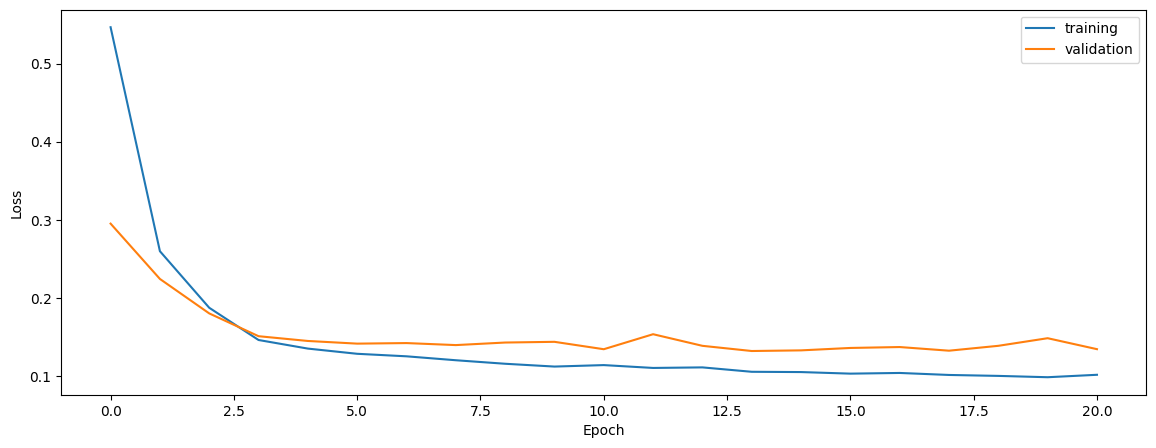

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.9598868828139675


0.9496831936114236


0.9563909078283412


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9598868828139675


0.9496831936114236


0.9563909078283412


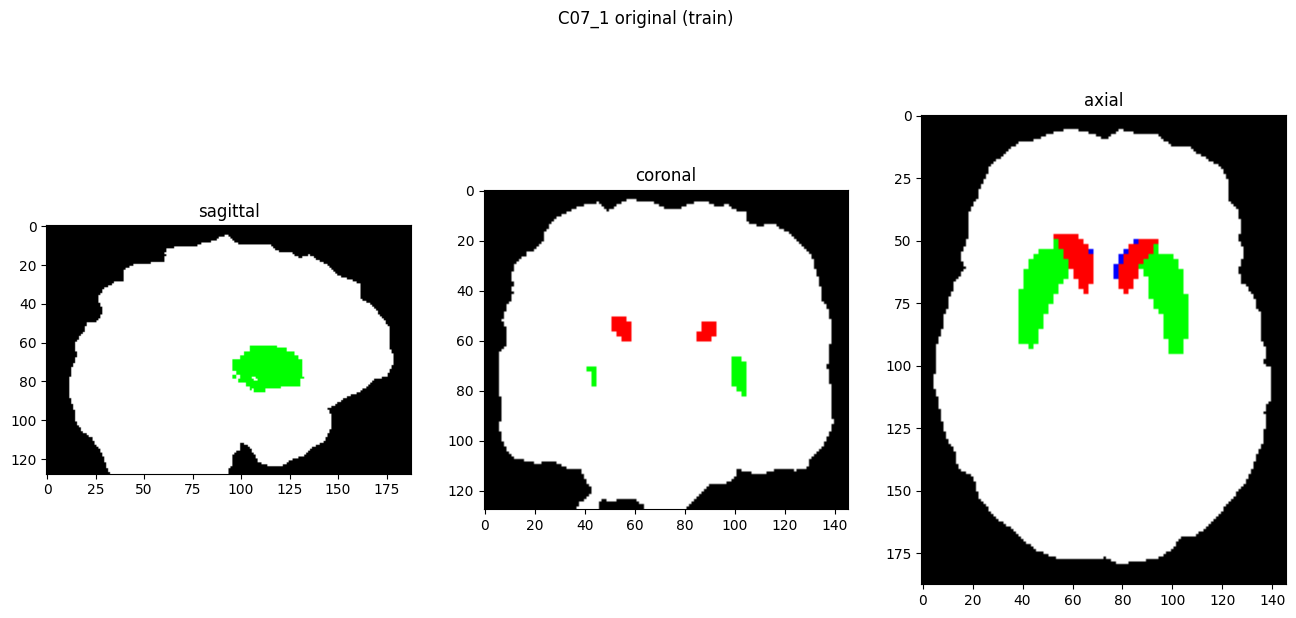

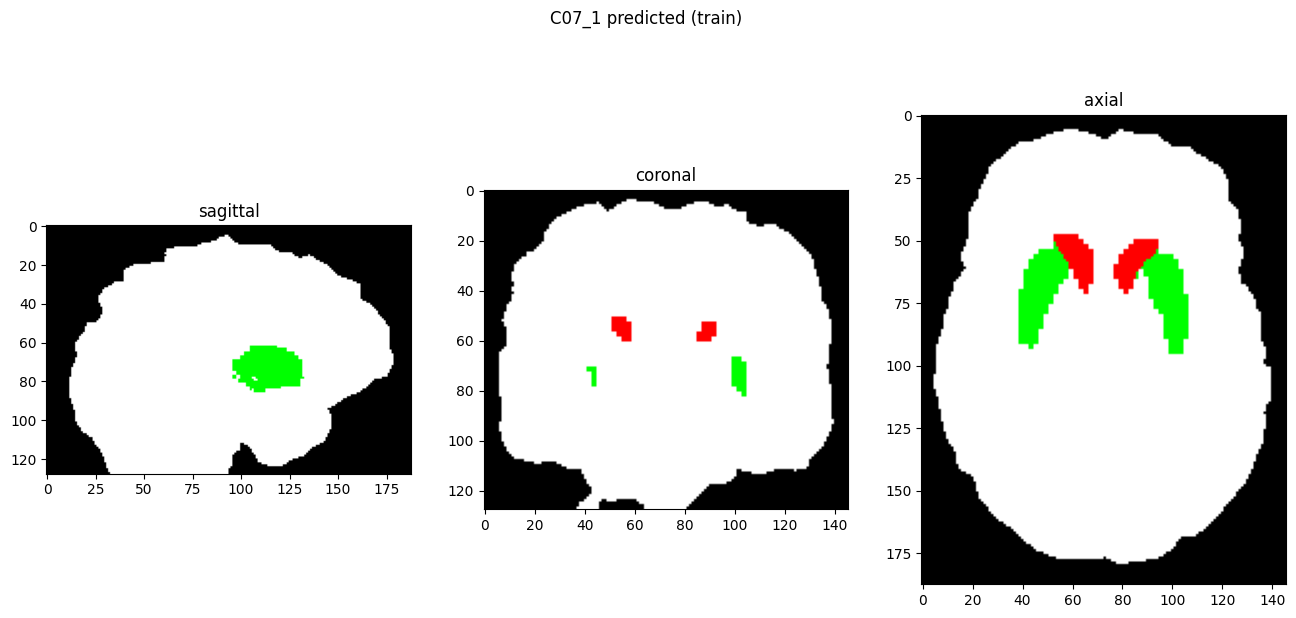

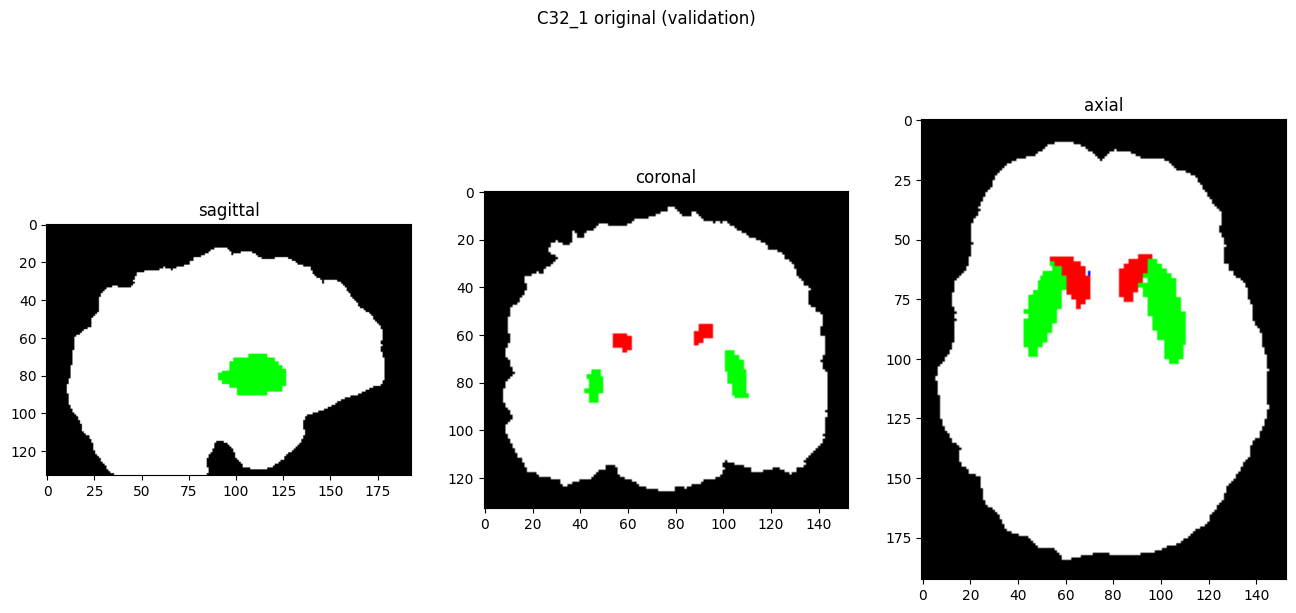

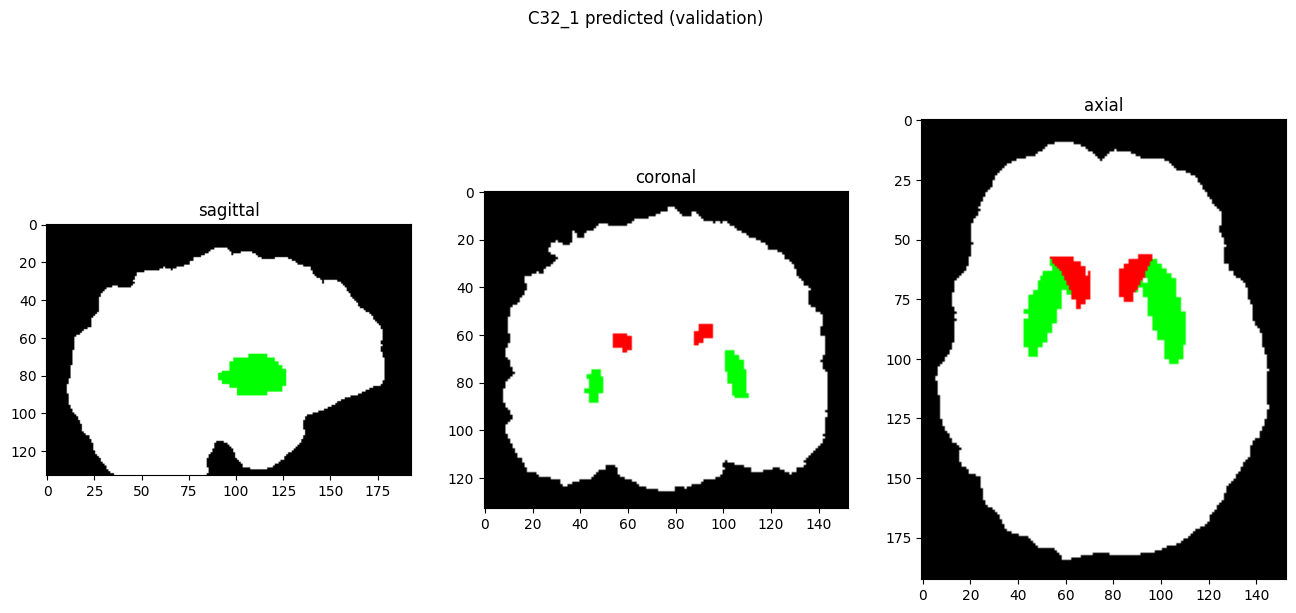

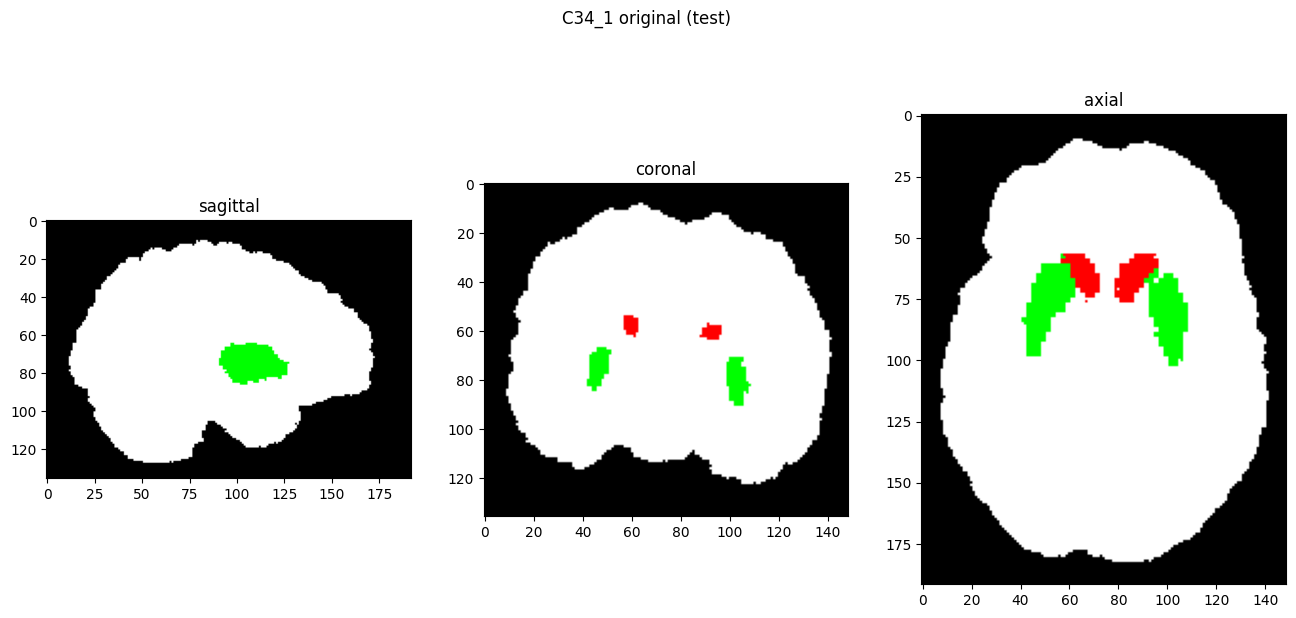

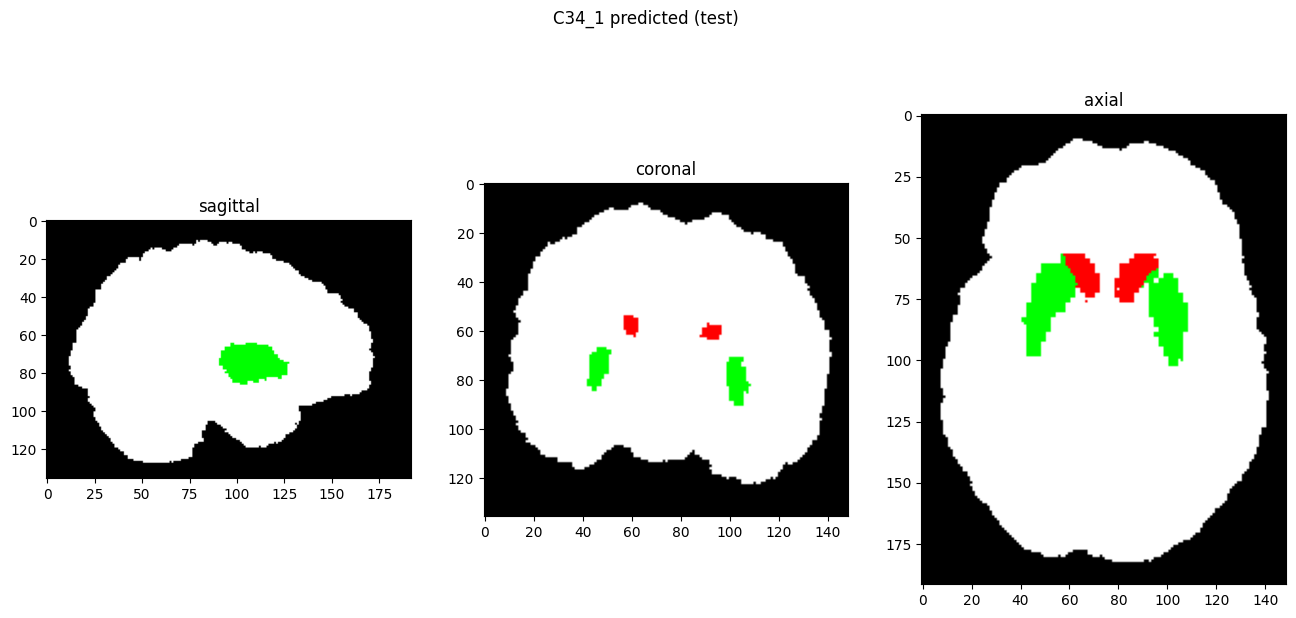

In [9]:
showResults(model, gen, threshold=0)